# Two Points On Parallel Lines solution with CCEM method¶


In [67]:
import torch
import numpy as np
import pandas
import matplotlib.pyplot as plt
from copy import deepcopy

## TODO

1) Get best gaurenteed result as 0 for CCEM method

2) Try dicsrete Cross-Entropy to improve

## Code implementation


### Evironment

In [68]:
class TwoPointsOnParallelLines:
    def __init__(self, initial_x=np.array([4.5, 0, 0, 0]), alpha=1, m1=0.01, m2=1, theta=10,
                 u_action_max=2.5, v_action_max=1, dt=0.005):
        self.initial_x = initial_x
        self.alpha = alpha
        self.m1 = m1
        self.m2 = m2
        self.theta = theta
        self.u_action_max = u_action_max
        self.v_action_max = v_action_max
        self.dt = dt
        self.state = self.reset()

    def reset(self):
        self.state = np.hstack((0, self.initial_x))
        return self.state

    def step(self, u_action, v_action):
        t, x1, x2, x3, x4 = self.state
        x1 = x1 + x2 * self.dt
        x2 = x2 + (- (self.alpha / self.m1) * x2 + (1 / self.m1) * u_action) * self.dt
        x3 = x3 + x4 * self.dt
        x4 = x4 + (1 / self.m2) * v_action * self.dt
        t += self.dt
        self.state = np.array([t, x1, x2, x3, x4])

        reward = 0
        done = False
        if t >= self.theta:
            reward = - np.abs(x1 - x3)
            done = True

        return self.state, reward, done, None


### CCME Agent

In [69]:
class Network(torch.nn.Module):
    """Neural network for an agent"""

    def __init__(self, input_shape, output_shape):
        """Create new network
        :param input_shape: input data shape
        :param output_shape: output data shape
        """
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_shape[0], 50)
        self.linear_2 = torch.nn.Linear(50, 30)
        self.linear_3 = torch.nn.Linear(30, output_shape[0])
        self.relu = torch.nn.ReLU()
        self.tang = torch.nn.Tanh()

    def forward(self, input_):
        """Network step
        :param input_: input data
        :return: network output result
        """
        hidden = self.relu(self.linear_1(input_))
        hidden = self.relu(self.linear_2(hidden))
        output = self.tang(self.linear_3(hidden))
        return output


In [70]:
class CCEMAgent(torch.nn.Module):
    """Continuous cross-entropy method agent implementation"""

    def __init__(self, state_shape, action_shape, action_max, reward_param=1, percentile_param=70, noise_decrease=0.98,
                 tau=1e-2, learning_rate=1e-2, n_learning_per_fit=16, mini_batch_size=200):
        """Create new agent
        :param state_shape: environment's state shape
        :param action_shape: agent's action shape
        :param action_max: maximum action value
        :param reward_param: equal to 1 if agent wants to maximize reward otherwise -1
        :param percentile_param: percentile to get elite sessions
        :param noise_decrease: noise decrease value
        :param tau: network weights updating rate
        :param learning_rate: learning rate for gradient descent method
        :param n_learning_per_fit: number of network updating weights iterations per fit
        :param mini_batch_size: count of elements to sample to mini-batch
        """
        super().__init__()
        self.action_max = np.abs(action_max)
        self.reward_param = reward_param
        self.percentile_param = percentile_param
        self.noise_decrease = noise_decrease
        self.noise_threshold = 1
        self.min_noise_threshold = 0.1
        self.tau = tau
        self.n_learning_per_fit = n_learning_per_fit
        self.mini_batch_size = mini_batch_size
        self.network = Network(state_shape, action_shape)
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

    def get_action(self, state, test=False):
        """Get an action by current state
        :param state: current environment state
        :param test: if True noise will not be added and will be otherwise
        :return: predicted action
        """
        state = torch.FloatTensor(state)
        predicted_action = self.network(state).detach().numpy() * self.action_max
        if not test:
            noise = self.noise_threshold * np.random.uniform(low=-self.action_max, high=self.action_max)
            predicted_action = np.clip(predicted_action + noise, -self.action_max, self.action_max)
        return predicted_action

    def get_elite_states_and_actions(self, sessions):
        """Select sessions with the most or least reward by percentile
        :param sessions: list of sessions to choose elite ones from
        :return: elite states, elite actions
        """
        total_rewards = [session['total_reward'] for session in sessions]
        reward_threshold = np.percentile(total_rewards, self.percentile_param)
        
        elite_states = []
        elite_actions = []
        for session in sessions:
            if self.reward_param * (session['total_reward'] - reward_threshold) > 0:
                elite_states.extend(session['states'])
                elite_actions.extend(session[f'{self}actions'])

        return torch.FloatTensor(elite_states), torch.FloatTensor(elite_actions)

    def learn_network(self, loss):
        """Update network weights by optimize loss
        :param loss: loss function to optimize
        :return: None
        """
        self.optimizer.zero_grad()
        old_network = deepcopy(self.network)
        loss.backward()
        self.optimizer.step()

        for new_parameter, old_parameter in zip(self.network.parameters(), old_network.parameters()):
            new_parameter.data.copy_(self.tau * new_parameter + (1 - self.tau) * old_parameter)

        return None

    def fit(self, sessions):
        """Fitting process using mini-batches
        :param sessions: sessions to fit on
        :return: None
        """
        elite_states, elite_actions = self.get_elite_states_and_actions(sessions)

        for _ in range(self.n_learning_per_fit):
            predicted_action = self.network(elite_states) * self.action_max
            loss = torch.mean((predicted_action - elite_actions) ** 2)
            self.learn_network(loss)

        if self.noise_threshold > self.min_noise_threshold:
            self.noise_threshold *= self.noise_decrease

        return None

    def __str__(self):
        """An agent string representation to define if it is u_agent or v_agent
        :return: string representation
        """
        return 'u_' if self.reward_param == -1 else 'v_'


### Generate sessions


In [71]:
def generate_session(first_agent, second_agent, env, n_iter_update, test=False):
    """Generate session on environment with agents with updating actions each n_iter_update-th time
    :param first_agent: first agent (u_agent by default)
    :param second_agent: second agent (v_agent by default)
    :param env: environment
    :param n_iter_update: number of iterations between getting new actions
    :param test: if True first agent will not add noise in get_action method
    :return: session dict wit states, first agent actions, second agent actions and total rewards
    """
    states = []
    first_agent_actions = []
    second_agent_actions = []
    total_reward = 0
    done = False
    state = env.reset()
    iteration = 0
    while not done:
        if iteration % n_iter_update == 0:
            first_agent_action = first_agent.get_action(state, test=test)
            second_agent_action = second_agent.get_action(state)
            states.append(state)
            first_agent_actions.append(first_agent_action)
            second_agent_actions.append(second_agent_action)
        actions = (first_agent_action[0], second_agent_action[0]) if str(first_agent) == 'u_' else (second_agent_action[0], first_agent_action[0])
        next_state, reward, done, _ = env.step(*actions)
        total_reward += reward
        state = next_state
        iteration += 1

    return {'states': states,
            f'{first_agent}actions': first_agent_actions,
            f'{second_agent}actions': second_agent_actions,
            'total_reward': total_reward}


### Fit one epoch


In [72]:
def fit_epoch(u_agent, v_agent, env, n_sessions, n_iter_update, test):
    """Fit agents during an one epoch
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_sessions: number of sessions
    :param n_iter_update: number of iterations between getting new actions
    :param test: if True u_agent will not be fitted
    :return: mean total reward over sessions
    """
    #sessions = [generate_session(u_agent, v_agent, env, test=test) for _ in range(n_sessions)]
    with torch.multiprocessing.Pool(torch.multiprocessing.cpu_count()) as pool:
        sessions = pool.starmap(generate_session, [(u_agent, v_agent, env, n_iter_update, test) for _ in range(n_sessions)])
    mean_reward = np.mean([session['total_reward'] for session in sessions])
    if not test:
        u_agent.fit(sessions)
    v_agent.fit(sessions)
    return mean_reward

### Test agents


In [73]:
def test_agent(u_agent, env, n_epochs, n_sessions, n_iter_update, epsilon):
    """Test u_agent by fit a new v_agent
    :param u_agent: agent to test (must be u_agent type)
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_sessions: number of sessions for one epoch
    :param n_iter_update: number of iterations between getting new actions
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :return: test total rewards
    """
    v_agent = CCEMAgent((5,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)
    _, rewards, _ = fit_agents(u_agent, v_agent, env, n_epochs, 0, n_sessions, n_iter_update, epsilon, test=True)
    return rewards

### Fit agents

In [88]:
def fit_agents(u_agent, v_agent, env, n_epochs, n_test_epochs, n_sessions, n_iter_update,
               epsilon, n_iter_debug=0, test=False):
    """Fit both agent together during several epochs
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_test_epochs: number of epochs to test
    :param n_sessions: number of sessions for one epoch
        :param n_iter_update: number of iterations between getting new actions
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :param n_iter_debug: number of iteration between tests
    :param test: if True u_agent will not be fitted
    :return: u_agent, mean total rewards, test total rewards
    """
    last_mean_reward = 0
    mean_rewards = []
    test_rewards = []
    epoch = 0

    for epoch in range(n_epochs):

        mean_reward = fit_epoch(u_agent, v_agent, env, n_sessions=n_sessions, n_iter_update=n_iter_update, test=test)
        mean_rewards.append(mean_reward)
        print(f'epoch: {epoch}, mean reward: {mean_reward}')
        if np.abs(last_mean_reward - mean_reward) < epsilon:
            break
        last_mean_reward = mean_reward

        if n_iter_debug and (epoch + 1) % n_iter_debug == 0:
            print('\n{:-^50}\n'.format('TEST BEGIN'))
            test_rewards.append(test_agent(u_agent, env, n_epochs=n_test_epochs, n_sessions=n_sessions, n_iter_update=n_iter_update, epsilon=epsilon))
            print('\n{:-^50}\n'.format('TEST END'))             

    return u_agent, np.array(mean_rewards), np.array(test_rewards)


### Fit agents one by one

In [89]:
def fit_agents_one_by_one(u_agent, v_agent, env, n_epochs, n_test_epochs, n_sessions, n_iter_update,
                          n_iter_for_fit, epsilon, n_iter_debug=0):
    """Fit agents ony by one during several epochs.
    During fix number of iterations one agent will be fitted while the other will not.
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_test_epochs: number of epochs to test
    :param n_sessions: number of sessions for one epoch
    :param n_iter_update: number of iterations between getting new actions
    :param n_iter_for_fit: number of iterations between agent switching
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :param n_iter_debug: number of iteration between tests
    :return: u_agent, mean  total rewards, test total rewards
    """
    last_mean_reward = 0
    mean_rewards = []
    test_rewards = []
    fitting_agent = u_agent
    awaiting_agent = v_agent
    epoch = 0
    stop = False

    while not stop and epoch < n_epochs:

        for _ in range(n_iter_for_fit):

            mean_reward = fit_epoch(awaiting_agent, fitting_agent, env, n_sessions=n_sessions, n_iter_update=n_iter_update, test=True)
            mean_rewards.append(mean_reward)
            print(f'epoch: {epoch}, current agent: {fitting_agent}, mean reward: {mean_reward}')
            if np.abs(last_mean_reward - mean_reward) < epsilon:
                stop = True
                break
            last_mean_reward = mean_reward

            if n_iter_debug and (epoch + 1) % n_iter_debug == 0:
                print('\n{:-^50}\n'.format('TEST BEGIN'))
                test_rewards.append(test_agent(u_agent, env, n_epochs=n_test_epochs, n_sessions=n_sessions, n_iter_update=n_iter_update, epsilon=epsilon))
                print('\n{:-^50}\n'.format('TEST END'))

            epoch += 1
            if epoch >= n_epochs:
                break

        print('\n')
        awaiting_agent, fitting_agent = fitting_agent, awaiting_agent

    return u_agent, np.array(mean_rewards), np.array(test_rewards)


### Fit random agent pairs

In [90]:
def fit_random_agent_pairs(u_agents, v_agents, env, n_pairs, n_epochs, n_test_epochs, n_sessions, n_iter_update, n_iter_debug=0):
    """ Fit random pairs of u_ and v_agents
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_pairs: number of pairs to fit
    :param n_epochs: number of epochs for one pair fit
    :param n_test_epochs: number of epochs to test
    :param n_sessions: number of sessions for one epoch
    :param n_iter_update: number of iterations between getting new actions
    :param n_iter_debug: number of iteration between tests
    :return: u_agent that will have minimum test total reward, mean total rewards for u_agents, test total rewards
    """
    u_agents_mean_rewards = [[] for _ in range(len(u_agents))]
    test_rewards = []

    for i in range(n_pairs):
        u_agent_idx = np.random.choice(len(u_agents))
        v_agent_idx = np.random.choice(len(v_agents))
        print(f'PAIR {i + 1} OF {n_pairs}')
        print('\n{:-^50}\n'.format(f'U_AGENT_{u_agent_idx} VS V_AGENT_{v_agent_idx}'))
        _, mean_rewards, _ = fit_agents(u_agents[u_agent_idx], v_agents[v_agent_idx],
                                        env=env, n_epochs=n_epochs, n_test_epochs=0, n_sessions=n_sessions,
                                        n_iter_update=n_iter_update, epsilon=-1, n_iter_debug=0)
        print('\n{:-^50}\n'.format(''))

        u_agents_mean_rewards[u_agent_idx].append(mean_rewards.min())

    for i, u_agent in enumerate(u_agents):
        print(f'\nTESTING U_AGENT_{i}\n')
        test_rewards.append(test_agent(u_agent, env, n_epochs=n_test_epochs, n_sessions=n_sessions, n_iter_update=n_iter_update, epsilon=-1))

    best_u_agent_idx = np.argmin([test.max() for test in test_rewards])
    print(f'\nBest agent is {best_u_agent_idx}, its test reward is {np.min(test_rewards[best_u_agent_idx])}\n')
    return u_agents[best_u_agent_idx], np.array(u_agents_mean_rewards), np.array(test_rewards)
    

### Plot mean rewards by epochs

In [96]:
def plot_mean_rewards(mean_rewards, method_name, axes, test_rewards=None):
    """Plot mean rewards
    :param mean_rewards: rewards to plot
    :param method_name: fitting method name
    :param test_rewards: test rewards to plot
    """
    if test_rewards is not None:
        ax1, ax2 = axes
    else:
        ax1 = axes
    ax1.plot(range(len(mean_rewards)), mean_rewards)
    ax1.set_xlabel('Номер эпохи')
    ax1.set_ylabel('Средний total reward')
    ax1.set_title(f'Среднее значение total reward для {method_name}')
    ax1.grid()
    if test_rewards is not None:
        ax2.set_xlabel('Номер эпохи')
        ax2.set_ylabel('Тестовый total reward')
        ax2.set_title(f'Тестовое значение total reward для {method_name}')
        for i, test_reward in enumerate(test_rewards):
            ax2.plot(range(len(test_reward)), test_reward, label=f'После {int((i + 1) * len(mean_rewards) / len(test_rewards))} эпох')
        ax2.legend(loc='best')
        ax2.grid()
    plt.tight_layout()
    plt.show()  

### Testing multiprocessing

In [59]:
env = TwoPointsOnParallelLines()

In [60]:
u_agent = CCEMAgent((5,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((5,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)

In [61]:
%%timeit
sessions = [generate_session(u_agent, v_agent, env, 100, test=False) for _ in range(100)]

1 loop, best of 3: 1.61 s per loop


In [46]:
s = generate_session(u_agent, v_agent, env, 100, test=False)

In [47]:
len(s['states'])

20

In [48]:
import multiprocessing

In [49]:
process_count = multiprocessing.cpu_count()
process_count

2

In [50]:
with torch.multiprocessing.Pool(process_count) as pool:
    %timeit pool.starmap(generate_session, [(u_agent, v_agent, env, 100, False) for _ in range(100)])

1 loop, best of 3: 3.35 s per loop


## Fitting

In [80]:
env = TwoPointsOnParallelLines()

### Deafualt fit

In [81]:
u_agent = CCEMAgent((5,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((5,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)

In [82]:
%%time
u_fit_agent, mean_rewards, test_rewards \
= fit_agents(u_agent, v_agent, env, n_epochs=500, n_test_epochs=300, n_sessions=100, n_iter_update=100, epsilon=-1, n_iter_debug=100)

epoch: 0, mean reward: -11.788785095163853
epoch: 1, mean reward: -8.957482755786238
epoch: 2, mean reward: -6.656517296882635
epoch: 3, mean reward: -5.72659201674869
epoch: 4, mean reward: -5.064929213386535
epoch: 5, mean reward: -4.7253294557433785
epoch: 6, mean reward: -4.176407350395813
epoch: 7, mean reward: -3.9748362824079453
epoch: 8, mean reward: -3.885165684339599
epoch: 9, mean reward: -3.9424332254001992
epoch: 10, mean reward: -3.907537781606011
epoch: 11, mean reward: -3.8672659745343503
epoch: 12, mean reward: -3.9316798191298847
epoch: 13, mean reward: -4.965042750385317
epoch: 14, mean reward: -4.0771723540348725
epoch: 15, mean reward: -3.6538756937931134
epoch: 16, mean reward: -3.3730178838812828
epoch: 17, mean reward: -4.2697553223167946
epoch: 18, mean reward: -3.204208398683096
epoch: 19, mean reward: -3.384958898062395
epoch: 20, mean reward: -3.248803658839523
epoch: 21, mean reward: -3.0674982030010396
epoch: 22, mean reward: -3.215724218868416
epoch: 23, 

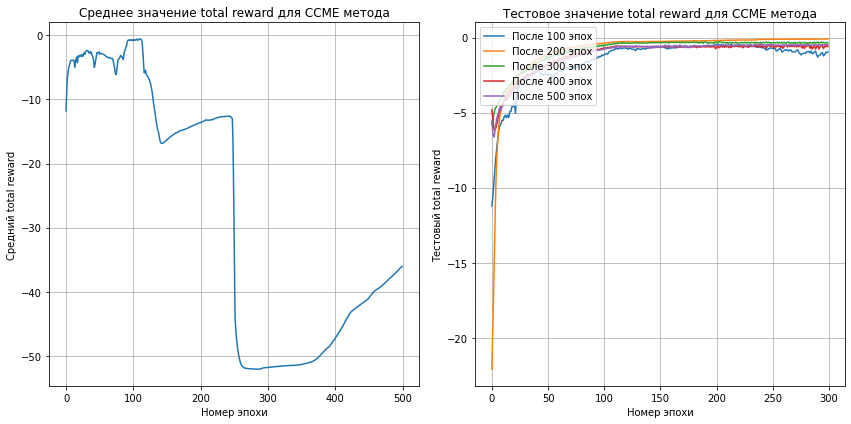

In [83]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_mean_rewards(mean_rewards, method_name='CCME метода', axes=axes, test_rewards=test_rewards)

### Fit one by one

In [92]:
u_agent_one_by_one = CCEMAgent((5,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)
v_agent_one_by_one = CCEMAgent((5,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)

In [94]:
%%time
u_fit_agent_one_by_one, mean_rewards_one_by_one, test_rewards_one_by_one =\
fit_agents_one_by_one(u_agent_one_by_one, v_agent_one_by_one, env, \
                       n_epochs=500, n_test_epochs=300, n_sessions=100, n_iter_for_fit=25, n_iter_update=100, epsilon=-1, n_iter_debug=100)

epoch: 0, current agent: u_, mean reward: -7.684780231528694
epoch: 1, current agent: u_, mean reward: -9.718715101999573
epoch: 2, current agent: u_, mean reward: -11.711573936858622
epoch: 3, current agent: u_, mean reward: -13.795989365866113
epoch: 4, current agent: u_, mean reward: -16.043946819177446
epoch: 5, current agent: u_, mean reward: -18.69609455115659
epoch: 6, current agent: u_, mean reward: -21.797201764898304
epoch: 7, current agent: u_, mean reward: -24.903219100172112
epoch: 8, current agent: u_, mean reward: -27.520662151776804
epoch: 9, current agent: u_, mean reward: -29.160401451431543
epoch: 10, current agent: u_, mean reward: -30.32319840323117
epoch: 11, current agent: u_, mean reward: -31.308578108119878
epoch: 12, current agent: u_, mean reward: -32.12850308200413
epoch: 13, current agent: u_, mean reward: -32.81453617598607
epoch: 14, current agent: u_, mean reward: -33.39010230851255
epoch: 15, current agent: u_, mean reward: -33.87624675449525
epoch: 16,

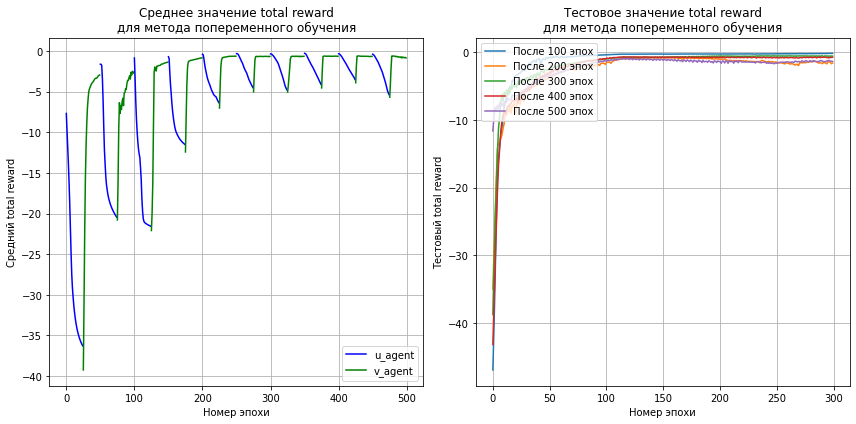

In [97]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

c = 'b'
l = 0

for rewards in np.array_split(mean_rewards_one_by_one, 20):
    ax1.plot(range(l, l + len(rewards)), rewards, color=c)
    l = l + len(rewards)
    c = 'b' if c=='g' else 'g'
ax1.set_xlabel('Номер эпохи')
ax1.set_ylabel('Средний total reward')
ax1.set_title('Среднее значение total reward\nдля метода попеременного обучения')
ax1.legend(labels=['u_agent', 'v_agent'])
ax1.grid()

ax2.set_xlabel('Номер эпохи')
ax2.set_ylabel('Тестовый total reward')
ax2.set_title('Тестовое значение total reward\nдля метода попеременного обучения')

for i, test_reward in enumerate(test_rewards_one_by_one):
    ax2.plot(range(len(test_reward)), test_reward, label=f'После {int((i + 1) * len(mean_rewards_one_by_one) / len(test_rewards_one_by_one))} эпох')
ax2.legend(loc='upper left')
ax2.grid()

plt.tight_layout()
plt.show()  

## Fit random pairs

In [ ]:
u_agents = [CCEMAgent((5,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)\
            for _ in range(5)]
v_agents = [CCEMAgent((5,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)\
            for _ in range(5)]

In [ ]:
%%time
u_fit_random_agent, mean_rewards_random, test_rewards_random = \
fit_random_agent_pairs(u_agents, v_agents, env,\
                       n_pairs=10, n_epochs=50, n_test_epochs=300, n_sessions=100,\
                       n_iter_update=100, n_iter_debug=10)

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, rewards in enumerate(mean_rewards_random):
    ax1.plot(range(len(rewards)), rewards, label=f'u_agent_{i}')

for i, test in enumerate(test_rewards_random):
    ax2.plot(range(len(test)), test, label=f'u_agent_{i}')

ax1.set_xlabel('Номер пары')
ax1.set_ylabel('Средний total reward')
ax1.set_title('Среднее значение total reward\nдля метода случайных пар')
ax1.grid()
ax1.legend(loc='upper left')

ax2.set_xlabel('Номер эпохи')
ax2.set_ylabel('Тестовый total reward')
ax2.set_title('Тестовое значение total reward\nдля каждого агента')
ax2.grid()
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Testing

Getting data

In [ ]:
import pandas as pd

In [ ]:
def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [ ]:
def get_test_data(test_rewards, test_rewards_one_by_one, test_rewards_random):
    data = np.vstack((test_rewards.max(axis=1),\
                      test_rewards_one_by_one.max(axis=1),\
                     test_rewards_random.max(axis=1)))
    return pd.DataFrame(data=data,\
                        columns=[f'После {i} эпох' for i in range(200, 1001, 200)],\
                        index=['CCME', 'Метод отложенного обучения', 'Метод случайных пар'])

In [ ]:
dt01_data = get_test_data(test_rewards, test_rewards_one_by_one, test_rewards_random)

In [ ]:
display(dt01_data.style.apply(highlight_min, axis=1))

,После 200 эпох,После 400 эпох,После 600 эпох,После 800 эпох,После 1000 эпох
CCME,0.754725,0.465713,0.405415,0.094068,0.057352
Метод отложенного обучения,9.110382,11.593006,0.781109,0.184886,0.217717
Метод случайных пар,7.059424,0.611673,2.273378,0.232129,0.526885
